<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score


In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
display(data)

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# проверяем в хронологическом ли порядке расположены даты и время

data.index.is_monotonic

True

In [5]:
display(data.head())

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

Данные с периодичностью в 10 минут, теперь ресемплируем их.

In [6]:
data = data.resample('1H').sum()

In [7]:
# проверим пропущенные значения
data.isnull().sum()

num_orders    0
dtype: int64

In [8]:
# проверим дубликаты 
data.duplicated().sum()

4165

Создадим переменные: в одной - исходные данные, в другой - применим разность рядов, чтобы сделять временной ряд более стационарным.

In [9]:
data_new = data.copy()
data_final = data.copy()

In [10]:
data['rolling_std'] = data['num_orders'].rolling(20).std()
data['rolling_mean'] = data['num_orders'].rolling(20).mean()

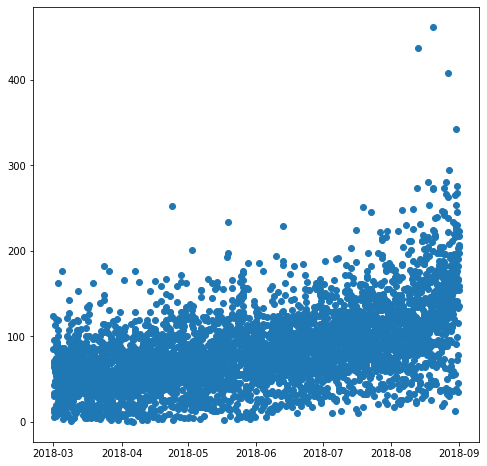

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(data.index.values, data['num_orders'])

plt.show()

Нам данны данные с марта по сентябрь 2018 года. Судя по графику рассеяния, мы видим, что большинство заказов находятся в промежутке от 0 до 100, вне зависимости от времени, также имеются выбросы. 

## Анализ

<AxesSubplot:xlabel='datetime'>

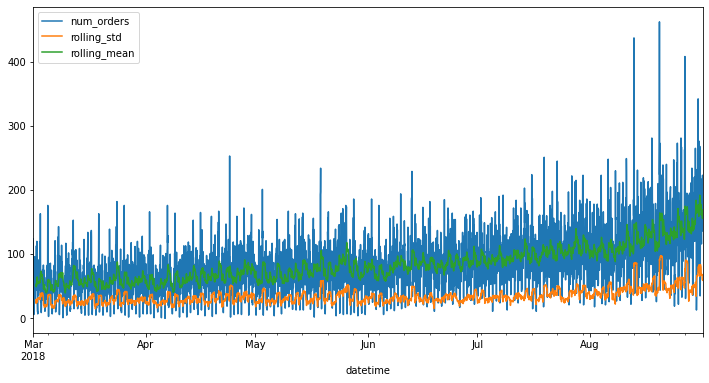

In [12]:
data.plot(figsize=(12, 6))

<AxesSubplot:xlabel='datetime'>

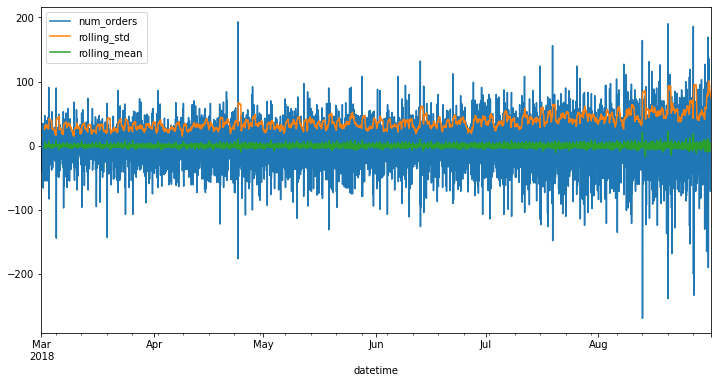

In [13]:
data_new = data - data.shift()
data_new['rolling_std'] = data_new['num_orders'].rolling(20).std()
data_new['rolling_mean'] = data_new['num_orders'].rolling(20).mean()

data_new.plot(figsize=(12, 6))

Изначально выборка уже и была стационарна (среднее значение и стандартное отклонение не меняются со временем), поэтому дальше так и использую изначальные признаки.  
(Если при проверке окажется не верно, то изменю на разность временного ряда)

Далее создадим признаки.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data_final, 2, 24)
print(data.head(10))

                     num_orders  rolling_std  rolling_mean
datetime                                                  
2018-03-01 00:00:00         124          NaN           NaN
2018-03-01 01:00:00          85          NaN           NaN
2018-03-01 02:00:00          71          NaN           NaN
2018-03-01 03:00:00          66          NaN           NaN
2018-03-01 04:00:00          43          NaN           NaN
2018-03-01 05:00:00           6          NaN           NaN
2018-03-01 06:00:00          12          NaN           NaN
2018-03-01 07:00:00          15          NaN           NaN
2018-03-01 08:00:00          34          NaN           NaN
2018-03-01 09:00:00          69          NaN           NaN


In [15]:
# удалим пропуски
data_final.dropna(inplace=True)

У функции make_features подбираем max_lag и rolling_mean_size экспериментальным путем.

Создадим графики тренда и сезонности.

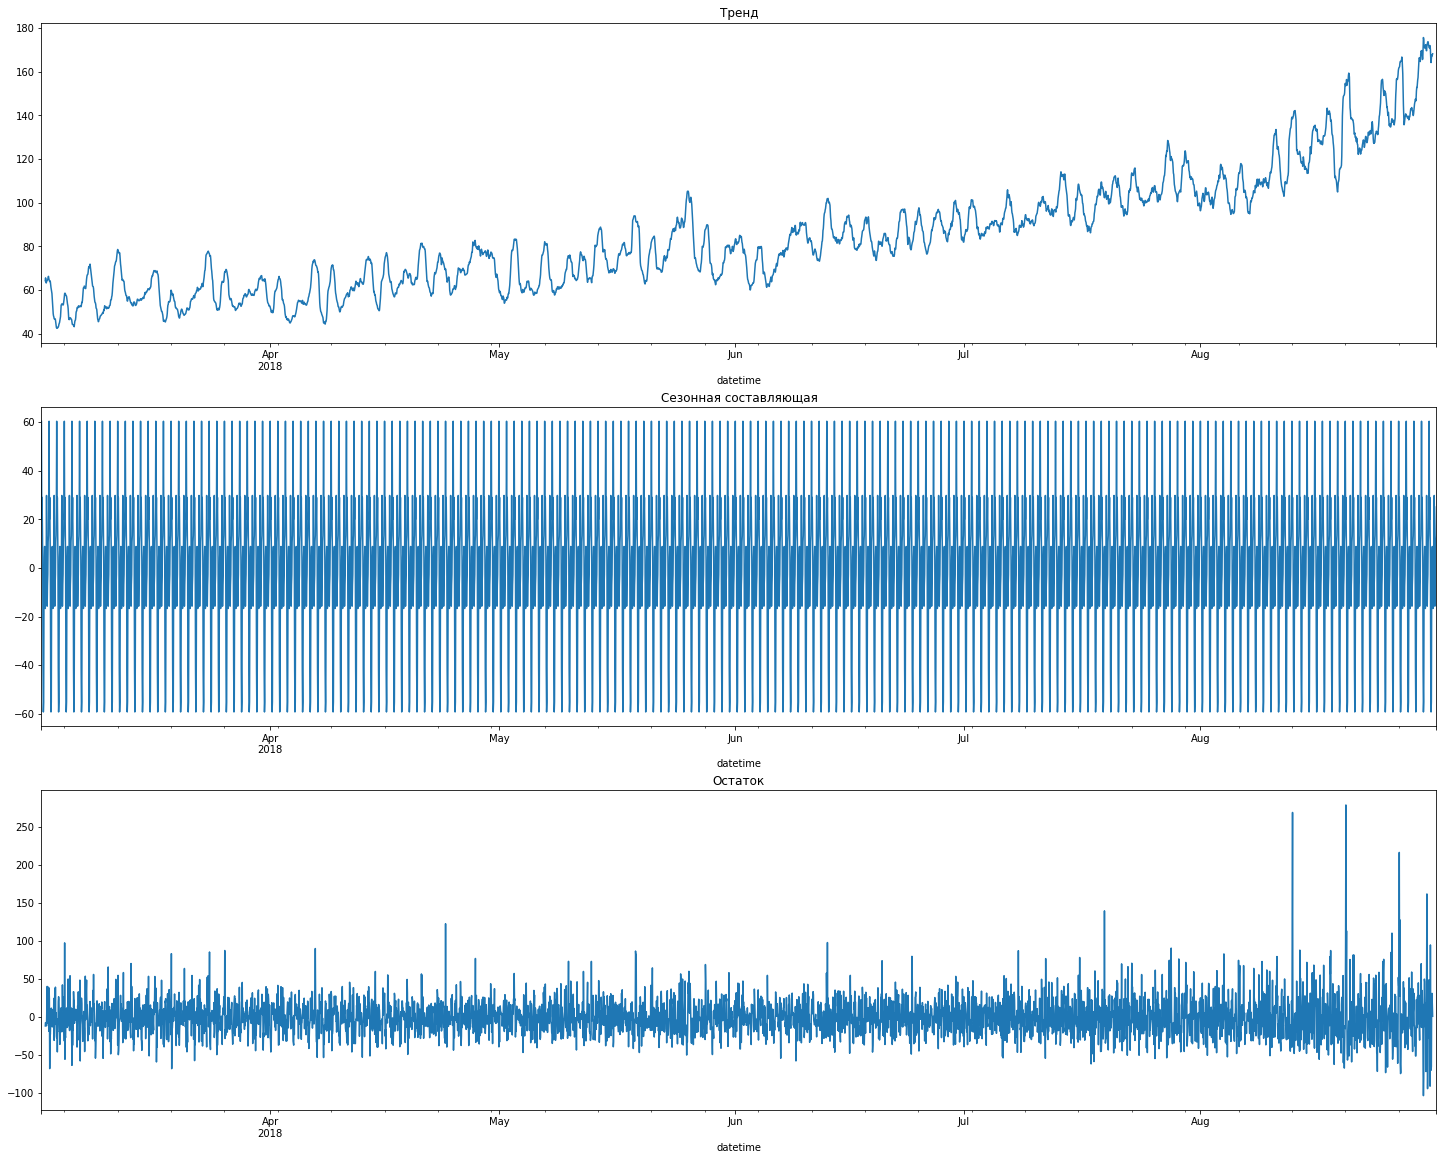

In [16]:
decomposed = seasonal_decompose(data_final['num_orders'])
fig,ax = plt.subplots(3,1,figsize = (25,20))

decomposed.trend.plot(ax=ax[0],title = 'Tренд')
decomposed.seasonal.plot(ax=ax[1],title = 'Cезонная составляющая')
decomposed.resid.plot(ax=ax[2],title = 'Остаток')

plt.show()

Построим график сезонной составляющей. Рассмотрим отдельный один день.

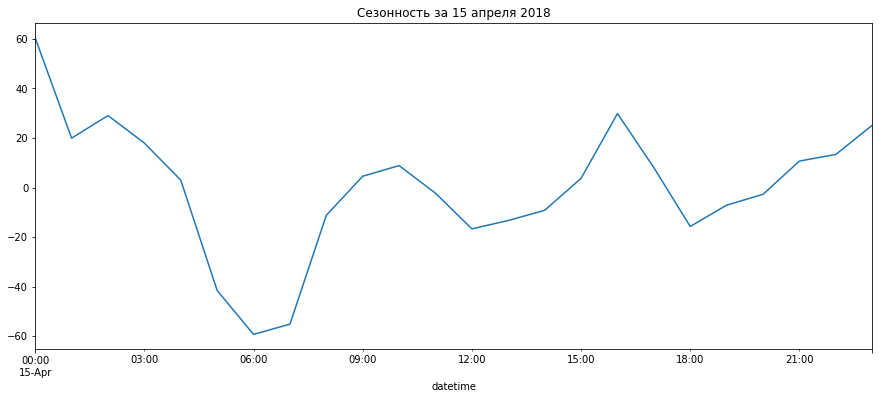

In [17]:
decomposed.seasonal['2018-04-15'].plot(figsize=(15, 6))
plt.title('Сезонность за 15 апреля 2018');

Text(0.5, 1.0, 'Сезонность за 15 июля 2018')

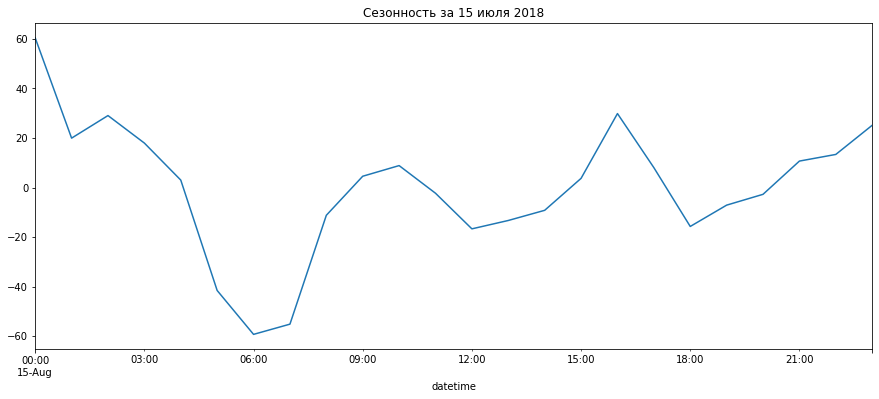

In [18]:
decomposed.seasonal['2018-08-15'].plot(figsize=(15, 6))
plt.title('Сезонность за 15 июля 2018')

Графики одинаковые, значит сезонность независима от времени. В начале каждого дня мы видим пик, потом резкий спад, затем в течение дня количество заказов растет и к концу дня достигает нового пика (пик уже будет следующего дня). 

Рассмотрим тренд одной недели. 

Text(0.5, 1.0, 'Тренд 5-11 марта 2018')

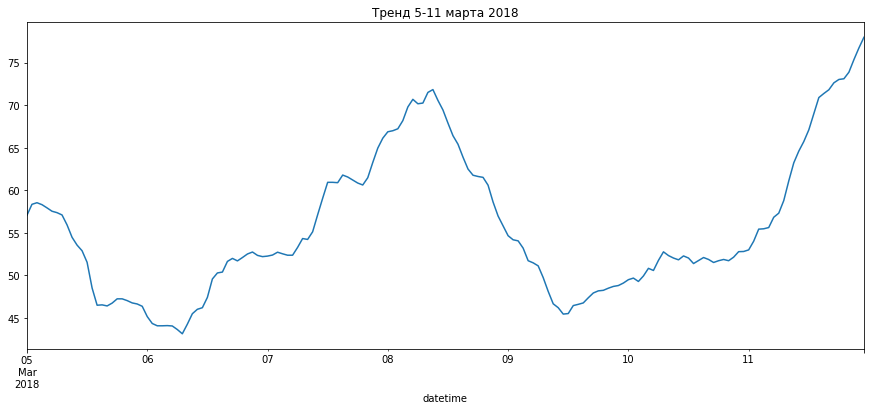

In [19]:
decomposed.trend['2018-03-05':'2018-03-11'].plot(figsize=(15, 6))
plt.title('Тренд 5-11 марта 2018') 

На графике тренда, мы видим, что рост тренда идет на середину недели, а также в понедельник.

## Обучение

In [22]:
train, test = train_test_split(data_final, shuffle=False, test_size=0.1)

In [23]:
print(test.shape)
print(train.shape)

(440, 6)
(3952, 6)


In [24]:
# проверим корректность деления
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [25]:
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

Я возьму такие модели:  
- Линейная регрессия 
- Случайный леc (регрессии) 
- Catboost

**Линейная регрессия**

In [26]:
%%time
model = LinearRegression()  
model.fit(features_train, target_train)

#pred_valid = model.predict(features_valid)
pred_train = model.predict(features_train)

print('RMSE обучающей выборки:', mean_squared_error(target_train, pred_train)**0.5)
#print('RMSE валидационной выборки:', mean_squared_error(target_valid, pred_valid)**0.5)

RMSE обучающей выборки: 30.887638490679436
CPU times: user 10.7 ms, sys: 1.05 ms, total: 11.8 ms
Wall time: 5.38 ms


In [27]:
%%time
model = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(model,features_train, target_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()* -1) 

Значение метрики RMSE на обучающей выборке для LinearRegression 31.377411422489168
CPU times: user 40.9 ms, sys: 3.51 ms, total: 44.4 ms
Wall time: 43.6 ms


**Случайный лес**

In [28]:
splits = TimeSeriesSplit(n_splits=8)

In [29]:
%%time
model = RandomForestRegressor(random_state=12345)
param = [{'max_depth': range(1,10), 'n_estimators':[100,150,10]}]
grid = GridSearchCV(model, param, verbose=True, cv = splits, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(features_train, target_train)
print(grid.best_params_)

Fitting 8 folds for each of 27 candidates, totalling 216 fits
{'max_depth': 9, 'n_estimators': 150}
CPU times: user 49.9 s, sys: 315 ms, total: 50.2 s
Wall time: 50.3 s


In [30]:
%%time
model = RandomForestRegressor(max_depth = 9, n_estimators = 150, random_state=12345)
model.fit(features_train, target_train)
#pred_valid = model.predict(features_valid)
pred_train = model.predict(features_train)

print('RMSE обучающей выборки:', mean_squared_error(target_train, pred_train)**0.5)
#print('RMSE валидационной выборки:', mean_squared_error(target_valid, pred_valid)**0.5)

RMSE обучающей выборки: 17.588590158679363
CPU times: user 1.04 s, sys: 3.9 ms, total: 1.05 s
Wall time: 1.05 s


**CatBoostRegressor**

In [31]:
%%time
model = CatBoostRegressor(loss_function='RMSE',random_state = 12345)
param = [{'depth':range(5,10), 'learning_rate':np.arange(0.1,1,0.2)}]
grid = model.grid_search(param,
            Pool(features_train, target_train),cv=splits,verbose=True)
print(grid.best_estimator_)


0:	learn: 72.3390530	test: 106.7169236	best: 106.7169236 (0)	total: 48ms	remaining: 47.9s
1:	learn: 66.4040311	test: 99.7730568	best: 99.7730568 (1)	total: 49.7ms	remaining: 24.8s
2:	learn: 61.1016889	test: 93.8334053	best: 93.8334053 (2)	total: 50.8ms	remaining: 16.9s
3:	learn: 56.4333514	test: 88.0230384	best: 88.0230384 (3)	total: 51.7ms	remaining: 12.9s
4:	learn: 52.2605171	test: 83.4073638	best: 83.4073638 (4)	total: 52.6ms	remaining: 10.5s
5:	learn: 48.5338430	test: 78.7123950	best: 78.7123950 (5)	total: 53.5ms	remaining: 8.86s
6:	learn: 45.3983813	test: 74.3712589	best: 74.3712589 (6)	total: 54.4ms	remaining: 7.72s
7:	learn: 42.5357056	test: 70.4960506	best: 70.4960506 (7)	total: 55.7ms	remaining: 6.91s
8:	learn: 40.0404769	test: 67.2507415	best: 67.2507415 (8)	total: 57.1ms	remaining: 6.29s
9:	learn: 37.4758419	test: 63.8495142	best: 63.8495142 (9)	total: 57.9ms	remaining: 5.73s
10:	learn: 35.5954959	test: 61.1876203	best: 61.1876203 (10)	total: 58.7ms	remaining: 5.28s
11:	lear

AttributeError: 'dict' object has no attribute 'best_estimator_'

In [32]:
%%time
model = CatBoostRegressor(n_estimators=200,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       random_state=12345, 
                       verbose=False)

model.fit(features_train, target_train) 
predicted_train = model.predict(features_train) 
#predicted_valid = model.predict(features_valid) 


print("RMSE обучающей выборки:", mean_squared_error(target_train, predicted_train) ** 0.5)
#print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE обучающей выборки: 18.203928802043134
CPU times: user 158 ms, sys: 12 ms, total: 170 ms
Wall time: 663 ms


**Вывод:** на валидационной выборке лучшая метрика качества RMSE у CatBoost и равна 31, значит для тестирования возьмем эту модель.

## Тестирование

In [33]:
%%time
model = CatBoostRegressor(n_estimators=200,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       random_state=12345, 
                       verbose=False)

model.fit(features_train, target_train) 
predicted_test = model.predict(features_test)

print("RMSE тестовой выборки:", mean_squared_error(target_test, predicted_test) ** 0.5)

RMSE тестовой выборки: 45.44399935726815
CPU times: user 143 ms, sys: 12.2 ms, total: 156 ms
Wall time: 850 ms


Построим график "Реального и предсказанного значения".

'Результаты модели <catboost.core.CatBoostRegressor object at 0x7fd4afc91190>'

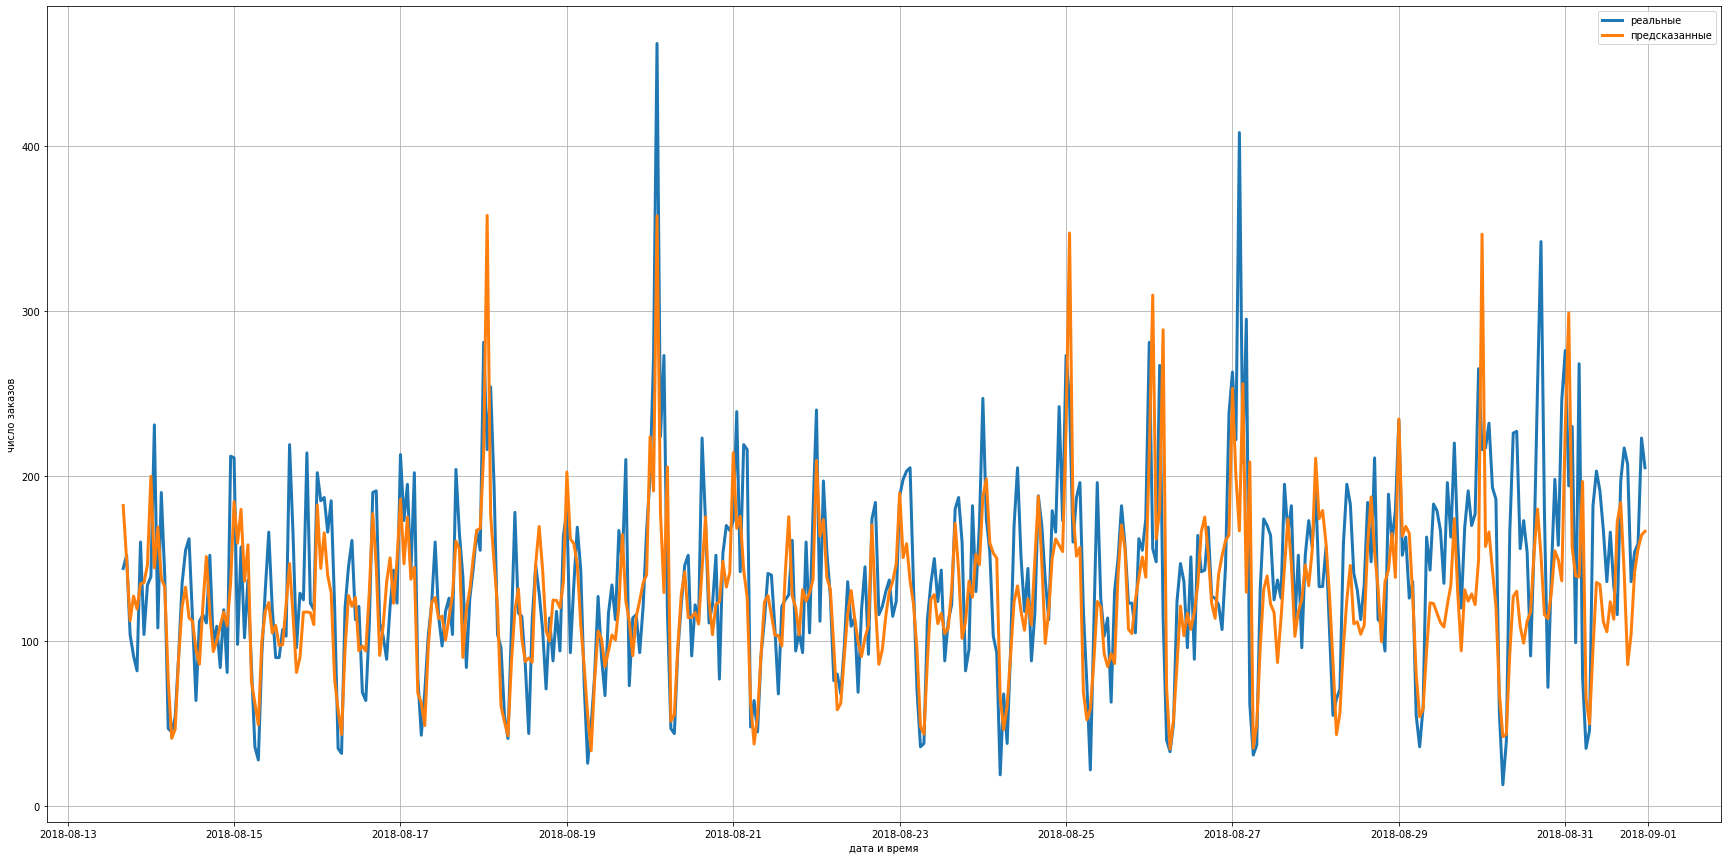

In [39]:
def plotting(pred_series, model):
    display(f'Результаты модели {model}')
    x = target_test.index
    y1, y2 = target_test, predicted_test
    plt.figure(figsize=(30, 15))
    plt.plot(x, y1, alpha=1, label='реальные', lw=3, mec='C5', mew=2, ms=10)
    plt.plot(x, y2, alpha=1, label='предсказанные', lw=3, mec='C5', mew=2, ms=10)
    plt.xlabel('дата и время')
    plt.ylabel('число заказов')
    plt.grid(True)
    plt.legend()
    
plotting(predicted_test, CatBR)
    

**Вывод:** на тестовой выборке метрика RMSE равна 45, нам по условию надо меньше 48. Модель соответсвует условию.